<a href="https://colab.research.google.com/github/Spinkk/Implementing-ANNs-with-Tensorflow/blob/main/08/ANN_w08_Minseok.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import time
import datetime

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
 
import tensorflow as tf
import tensorflow_datasets as tfds 

# 1. Data set
Data preprocessing is analogous to what has been done in week 7 (autoencoders). Notice that labels are not needed for GAN.

In [ ]:
def preprocess_tfds(dataset, batch_size=32, buffer_size=1024, prefetch_factor=tf.data.experimental.AUTOTUNE, shuffle=True):
    '''
    Create an input pipeline from tf.dataset. 
    Adjusted to only take input as there are no labels for autoencoders.
    Does only do input pipeline optimization when desired (inputs are not None)

    :param dataset: tf.dataset to preprocess
    :param batch_size: int, default batch size is 32
    :param buffer_size: int, default is 1024
    :param prefetch_factor: int, default prefetch size is TF autotune
    :returns: preprocessed tf.dataset
    ''' 
    
    # only use batching if shuffle is set to False
    if not shuffle:
        dataset = dataset.batch(batch_size, drop_remainder=True)
    else:
        dataset = dataset.shuffle(buffer_size).batch(batch_size, drop_remainder=True)
    
    # casting of the images to float32 and expanding dim since there is no channel dim
    # dividing by 255 to min-max scale the input
    # drop the label is it is not needed
    dataset = dataset.map(lambda img, label: tf.cast(img, tf.float32)/255, 
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # prefetch the dataset using AUTOTUNE to automatically find the optimal number of batches to prefetch
    if not prefetch_factor is None:
        dataset = dataset.prefetch(prefetch_factor)
    return dataset


## label codes for later analysis/visualization of encoded dataset
label_code = ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

# load the entire dataset from tfds (you can also get fashion_mnist from keras)
train_ds, test_ds = tfds.load('fashion_mnist', 
                              split=['train', 'test'], 
                              as_supervised=True, 
                              shuffle_files=False)


train_ds = preprocess_tfds(train_ds)
test_ds = preprocess_tfds(test_ds)

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete1RZ5RC/fashion_mnist-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete1RZ5RC/fashion_mnist-test.tfrecord


Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


# 2. Model
 - Discriminator

input: picture (dim: batch_size x width x height x filter_num)

output: real value between 0 and 1 (1 is 100% sure that the picture is real, 0 is 100% sure it's generated)

Use convolution and dense layer at the end

\
- Generator

input - noise from latent dimension, output - fake picture

Use dense layer, reshape to image, then transposed convolution to generate an image


In [ ]:
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.slayers = [tf.keras.layers.Conv2D(filters=32,
                                               kernel_size=3,
                                               strides=(2,2),
                                               input_shape=(None,28,28,1)),
                        tf.keras.layers.BatchNormalization(),
                        tf.keras.layers.Activation('relu'),
                        tf.keras.layers.Conv2D(filters=64,
                                               kernel_size=3,
                                               strides=(2,2)),
                        tf.keras.layers.BatchNormalization(),
                        tf.keras.layers.Activation('relu'),
                        tf.keras.layers.Flatten(),
                        # binary decision of fake/real data
                        tf.keras.layers.Dense(1, activation='sigmoid')]


    def call(self, x, training=False):
        for layer in self.slayers:
            try:  # training argument only for BN layer
                x = layer(x, training) 
            except:
                x = layer(x)
        return x




class Generator(tf.keras.Model):
    def __init__(self, latent_dim=100, restore_shape=(7,7,64)):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.slayers = [tf.keras.layers.Dense(units=int(tf.math.reduce_prod(restore_shape)),
                                             input_shape=(latent_dim,)),
                       tf.keras.layers.BatchNormalization(),
                       tf.keras.layers.Activation('relu'),
                       # reshape to 3 dim with depth dim again
                       tf.keras.layers.Reshape(target_shape=restore_shape),
                       # (2,2) strided transposed conv to upsample        
                       tf.keras.layers.Conv2DTranspose(filters=32,
                                                       kernel_size=(3,3),
                                                       strides=(2,2),
                                                       padding='same'),
                       tf.keras.layers.BatchNormalization(),
                       tf.keras.layers.Activation('relu'),
                       # restore image by convolution with image size
                       tf.keras.layers.Conv2DTranspose(filters=1,
                                                       kernel_size=(3,3),
                                                       strides=(2,2),
                                                       padding='same'),
                       tf.keras.layers.BatchNormalization(),
                       # use sigmoid to get values between 0 and 1
                       tf.keras.layers.Activation('sigmoid')]


    def call(self, x, training=False):
        for layer in self.slayers:
            try:  # training argument only for BN layer
                x = layer(x, training) 
            except:
                x = layer(x)
        return x


# 3. Training

- generator tries to trick discriminator. Thus only the 'trick rate' matters.

- discriminator tries to classify real images from generated images. Loss function should take both into account

- Loss at test phase doesn't tell us much. Instead, we should rather look at generated pictures. 

### Functions

In [ ]:
@tf.function
def training_step_GAN(data, model_gen, model_disc, loss_f_disc, loss_f_gen,
                      disc_optimizer, gen_optimizer, metric_gen, metric_disc,
                      n_disc=1):
    '''
    Train discriminator for n_disc epochs and generator for 1 epoch.
    For vanila GAN, n_disc = 1.
    '''  
    # Train Discriminator n_disc times more. Used for WGAN.  
    for epoch_disc in range(n_disc):
        for batch_true in data:
            with tf.GradientTape() as tape_disc: 
                # generate fake data
                noise_in_z = tf.random.normal([tf.shape(batch_true)[0], model_gen.latent_dim])
                batch_gen = model_gen(noise_in_z)  
                # prediction (logistic) of discriminator
                fake_pred = model_disc(batch_gen, training=True)
                true_pred = model_disc(batch_true, training=True)
                # compute loss. Arguments should be handed in right orders
                loss_disc = loss_f_disc(fake_pred, true_pred)
            # compute gradient dl/dw
            g_disc = tape_disc.gradient(loss_disc, model_disc.trainable_variables)
            # gradient descent
            disc_optimizer.apply_gradients(zip(g_disc, model_disc.trainable_variables))
            # save mean loss values
            metric_disc.update_state(loss_disc)


    # Train Generator
    for batch_true in data:
        with tf.GradientTape() as tape_gen:
            noise_in_z = tf.random.normal([tf.shape(batch_true)[0], model_gen.latent_dim])
            batch_gen = model_gen(noise_in_z, training=True)
            fake_pred = model_disc(batch_gen)
            true_pred = model_disc(batch_true)  
            loss_gen = loss_f_gen(fake_pred)
        g_gen = tape_gen.gradient(loss_gen, model_gen.trainable_variables)
        gen_optimizer.apply_gradients(zip(g_gen, model_gen.trainable_variables))
        metric_gen.update_state(loss_gen)
    

def evaluation_step_GAN(model_gen, num_image=10):
    '''
    Plot generated images
    '''
    num_row = (num_image-1) // 5  + 1
    num_col = 5
    fig, ax = plt.subplots(nrows=num_row, ncols=num_col, figsize=(20,4*num_row))

    # create num_image images
    for i in range(num_image):
        noise_in_z = tf.expand_dims(tf.random.normal([generator.latent_dim]),0)
        img_gen = model_gen(noise_in_z)  # use generator to get create images
        ax[i//5, i%5].imshow(img_gen[0,:,:,0], cmap='gray')
        ax[i//5, i%5].set(xticks=[], yticks=[], xticklabels=[], yticklabels=[])
    plt.show()

In [ ]:
class Timer():
    """
    A small class to measure time during training.
    """
    def __init__(self):
        self._start_time = None


    def start(self):
        """
        Start a new timer
        """
        if self._start_time is not None:
            print(f"Timer is running. Use .stop() to stop it")
            return None

        self._start_time = time.perf_counter()


    def stop(self):
        """
        Stop the timer, and report the elapsed time
        """
        if self._start_time is None:
            print(f"Timer is not running. Use .start() to start it")
            return 0
    
        elapsed_time = time.perf_counter() - self._start_time
        self._start_time = None
        return elapsed_time

### Design of model

In [ ]:
# Hyperparameters
epochs = 25
learning_rate_disc = 0.0001
learning_rate_gen = 0.0001
latent_dim = 100

tf.keras.backend.clear_session()  # clear session from previous models
timer = Timer()  # instantiate the timer

# architecture
generator = Generator()
discriminator = Discriminator()
generator.build((None,latent_dim))
discriminator.build((None,28,28,1))
generator.summary()
discriminator.summary()

# optimizer
adam_disc = tf.keras.optimizers.Adam(learning_rate_disc)
adam_gen = tf.keras.optimizers.Adam(learning_rate_gen)

# loss function
bce = tf.keras.losses.BinaryCrossentropy()
loss_disc_vanila = lambda fake_pred, true_pred: bce(tf.zeros_like(fake_pred), fake_pred) + bce(tf.ones_like(true_pred), true_pred)
loss_gen_vanila = lambda fake_pred: bce(tf.ones_like(fake_pred), fake_pred) 

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  316736    
_________________________________________________________________
batch_normalization (BatchNo multiple                  12544     
_________________________________________________________________
activation (Activation)      multiple                  0         
_________________________________________________________________
reshape (Reshape)            multiple                  0         
_________________________________________________________________
conv2d_transpose (Conv2DTran multiple                  18464     
_________________________________________________________________
batch_normalization_1 (Batch multiple                  128       
_________________________________________________________________
activation_1 (Activation)    multiple                  0 

### Init recording objects

In [ ]:
# take mean over different data points in the training loop
train_loss_gen = tf.keras.metrics.Mean('generator')
train_loss_disc = tf.keras.metrics.Mean('discriminator')

# initialize the logger for Tensorboard visualization
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train_GAN'      # defining the log dir
train_summary_writer = tf.summary.create_file_writer(train_log_dir)  # training logger

# Initialize lists for later visualization.
train_losses_disc = []
train_losses_gen = []
times = []

### Main loop


[EPOCH] ____________________0____________________
Timer is running. Use .stop() to stop it
[0] - Finished Epoch in 82.09 seconds - train_loss_disc: 0.0000, train_loss_gen: 0.0000


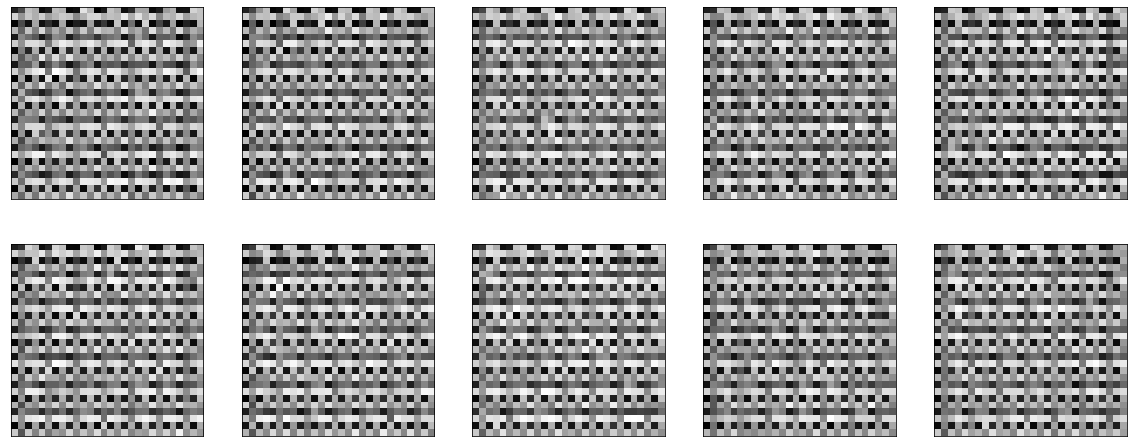


[INFO] - Total time elapsed: 16.7227 min. Total time remaining: 401.3442 min.

[EPOCH] ____________________1____________________
[1] - Finished Epoch in 9.48 seconds - train_loss_disc: 0.0000, train_loss_gen: 0.0000


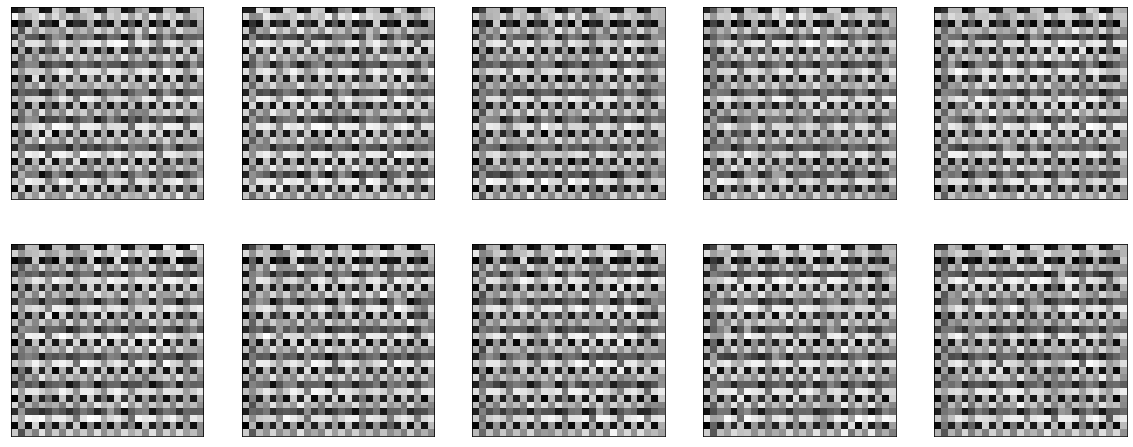


[EPOCH] ____________________2____________________
[2] - Finished Epoch in 9.51 seconds - train_loss_disc: 0.0000, train_loss_gen: 0.0000


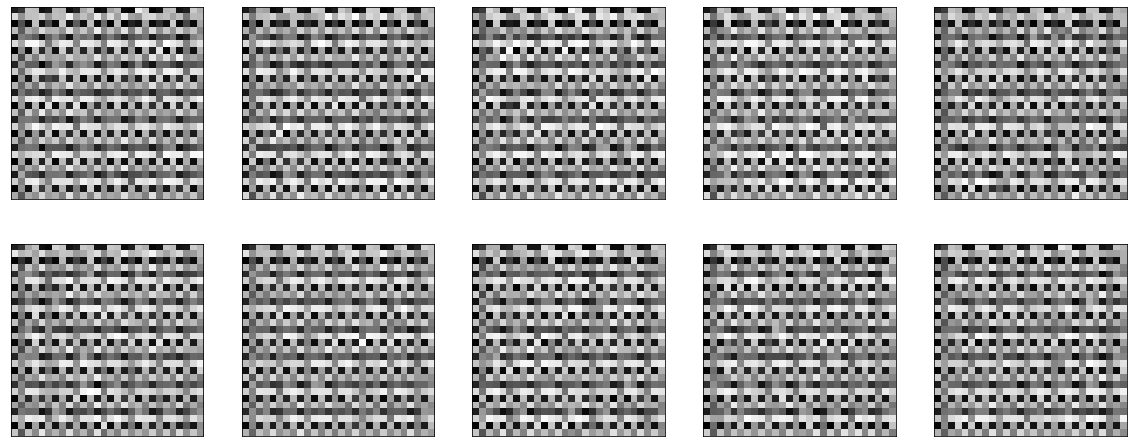


[EPOCH] ____________________3____________________
[3] - Finished Epoch in 10.08 seconds - train_loss_disc: 0.0000, train_loss_gen: 0.0000


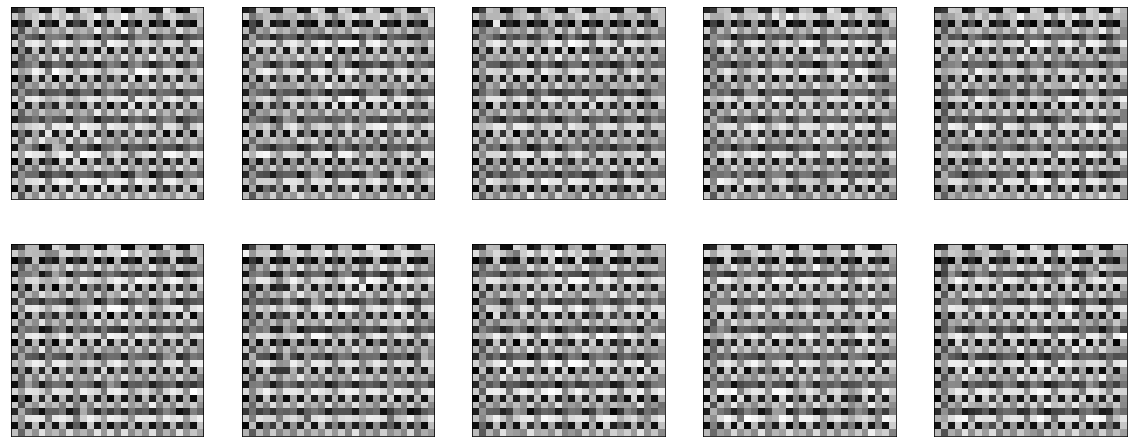


[INFO] - Total time elapsed: 17.2280 min. Total time remaining: 90.4473 min.

[EPOCH] ____________________4____________________


KeyboardInterrupt: ignored

In [ ]:
for epoch in range(epochs):
    print(f'\n[EPOCH] ____________________{epoch}____________________')
    
    # Training
    timer.start()
    training_step_GAN(train_ds, generator, discriminator, 
                      loss_disc_vanila, loss_gen_vanila, adam_disc, adam_gen, 
                      train_loss_disc, train_loss_gen)
    
    # logging our metrics to a file which is used by tensorboard
    with train_summary_writer.as_default():     
        tf.summary.scalar('discriminator', train_loss_disc.result(), step=epoch)
        tf.summary.scalar('generator', train_loss_gen.result(), step=epoch)
    # log losses and reset logging metrics
    train_loss_disc.reset_states()
    train_loss_gen.reset_states()
    # time and print progress
    elapsed_time = timer.stop()
    times.append(elapsed_time)
    print(f'[{epoch}] - Finished Epoch in {elapsed_time:0.2f} seconds - train_loss_disc: {train_loss_disc.result() :0.4f}, train_loss_gen: {train_loss_gen.result() :0.4f}')
    
    # Test (visualize)
    timer.start()
    generated_image = evaluation_step_GAN(generator)
    elapsed_time = timer.stop()
    times.append(elapsed_time)
    plt.show()
  
    # Print progress
    if epoch%3 == 0:
        print(f'\n[INFO] - Total time elapsed: {np.sum(times)/60:0.4f} min. Total time remaining: {(np.sum(times)/(epoch+1))*(epochs-epoch-1)/60:0.4f} min.')

print(f'[INFO] - Total run time: {np.sum(times)/60:0.4f} min.')

### Visualize loss

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir logs/gradient_tape

Screenshot of the training results on Tensorboard

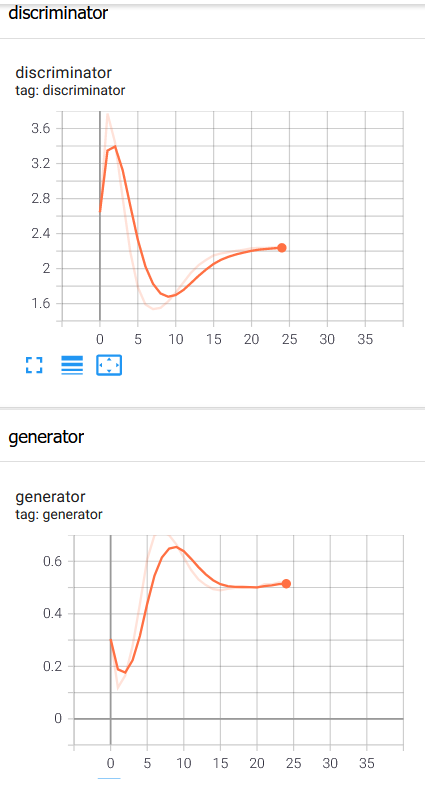

# Extra. WGAN
based on https://wiseodd.github.io/techblog/2017/02/04/wasserstein-gan/

Diffences to vanila GAN:

1) loss functions: use Wasserstein distance

2) clipping of $w_{disc}$ to enforce Lipschitz-continuity

3) the discriminator is trained more often than the generator

4) optimizer (RMSprop instead of Adam)

5) smaller learning rate (0.00005)

### Model

In [ ]:
class ClipConstraint(tf.keras.constraints.Constraint):
    '''
    Constrain the range of weights in WGAN discriminator by 
    clipping to satisfy Lipschitz-continuity naively
    '''


    def __init__(self, minval=-0.01, maxval=0.01):
        self.min = minval
        self.max = maxval


    def __call__(self, weights):
        return tf.clip_by_value(weights, self.min, self.max)


    def get_config(self):
        return {'minimum clip value': self.min, 'maximum clip value': self.max}


class WassersteinDiscriminator(tf.keras.Model):
    '''
    Analogous to a vanila discriminator except for usage of clipping and 
    linear activation instead of sigmoid at output layer.
    '''


    def __init__(self):
        super(WassersteinDiscriminator, self).__init__()
        self.slayers = [tf.keras.layers.Conv2D(filters=32,
                                               kernel_size=3,
                                               strides=(2,2),
                                               bias_constraint=ClipConstraint(),
                                               kernel_constraint=ClipConstraint(),
                                               input_shape=(None,28,28,1)),
                        tf.keras.layers.BatchNormalization(),
                        tf.keras.layers.Activation('relu'),
                        tf.keras.layers.Conv2D(filters=64,
                                               kernel_size=3,
                                               strides=(2,2),
                                               bias_constraint=ClipConstraint(),
                                               kernel_constraint=ClipConstraint()),
                        tf.keras.layers.BatchNormalization(),
                        tf.keras.layers.Activation('relu'),
                        tf.keras.layers.Flatten(),
                        # binary decision of fake/real data
                        tf.keras.layers.Dense(1,  # linear activation
                                              bias_constraint=ClipConstraint(),
                                              kernel_constraint=ClipConstraint())]

                                              

    def call(self, x, training=False):
        for layer in self.slayers:
            try:  # training argument only for BN layer
                x = layer(x, training) 
            except:
                x = layer(x)
        return x

### Design choices

In [ ]:
# Hyperparameters
epochs = 25
n_disc = 5  # discriminator is trained epochs x n_disc times
learning_rate_disc = 0.00005  # smaller learning rate
learning_rate_gen = 0.00005
latent_dim = 100

tf.keras.backend.clear_session()  # clear session from previous models
timer = Timer()  # Instantiate the timer

# Architeture
generator = Generator()
discriminator = WassersteinDiscriminator()
generator.build((None,latent_dim))
discriminator.build((None,28,28,1))
generator.summary()
discriminator.summary()

# Optimizer: RMSprop as in the original paper
opti_disc = tf.keras.optimizers.RMSprop(learning_rate_disc)
opti_gen = tf.keras.optimizers.RMSprop(learning_rate_gen)

# Loss function: sign is reversed and log isn't used anymore
loss_disc_WGAN = lambda fake_pred, true_pred: tf.reduce_mean(true_pred) - tf.reduce_mean(fake_pred)
loss_gen_WGAN = lambda fake_pred: -tf.reduce_mean(fake_pred)

### Init recording objects

In [ ]:
# take mean over different data points in the training loop
train_loss_gen = tf.keras.metrics.Mean('generator')
train_loss_disc = tf.keras.metrics.Mean('discriminator')

# initialize the logger for Tensorboard visualization
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train_WGAN'      # defining the log dir
train_summary_writer = tf.summary.create_file_writer(train_log_dir)  # training logger

# Initialize lists for later visualization.
train_losses_disc = []
train_losses_gen = []
times = []

### Main loop

In [ ]:
for epoch in range(epochs):
    print(f'\n[EPOCH] ____________________{epoch}____________________')
    
    # Training
    timer.start()
    training_step_GAN(train_ds, generator, discriminator,
                      # use WGAN loss 
                      loss_disc_WGAN, loss_gen_WGAN, adam_disc, adam_gen, 
                      train_loss_disc, train_loss_gen)
    
    # logging our metrics to a file which is used by tensorboard
    with train_summary_writer.as_default():     
        tf.summary.scalar('discriminator', train_loss_disc.result(), step=epoch)
        tf.summary.scalar('generator', train_loss_gen.result(), step=epoch)
    # log losses and reset logging metrics
    train_loss_disc.reset_states()
    train_loss_gen.reset_states()
    # time and print progress
    elapsed_time = timer.stop()
    times.append(elapsed_time)
    print(f'[{epoch}] - Finished Epoch in {elapsed_time:0.2f} seconds - train_loss_disc: {train_loss_disc.result() :0.4f}, train_loss_gen: {train_loss_gen.result() :0.4f}')
    
    # Test (visualize)
    timer.start()
    generated_image = evaluation_step_GAN(generator)
    elapsed_time = timer.stop()
    times.append(elapsed_time)
    plt.show()
  
    # Print progress
    if epoch%3 == 0:
        print(f'\n[INFO] - Total time elapsed: {np.sum(times)/60:0.4f} min. Total time remaining: {(np.sum(times)/(epoch+1))*(epochs-epoch-1)/60:0.4f} min.')

print(f'[INFO] - Total run time: {np.sum(times)/60:0.4f} min.')

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir logs/gradient_tape

is this a checkerboard artifact?

Also, the training func seems like it cannot be used twice (non-first excute error or something)

How tensorboard tracker should be reconfigured to average over $n_{disc}$ trials